In [1]:
# These are the packages used
using Pkg
using DataFrames
using Queryverse
using SQLite
using Statistics

# To install packages try: Pkg.add(["DataFrames", "Queryverse", "SQLite", "IJulia", "Statistics"])

## Objective

To rank the violation rate of doctors based on the incidence of surgery for benign polyps.

## Data

Medical data was was uploaded from SQLite Database provided by Sarner.  Diagnosis ICD-9-CM (D variables) and ICD-9-PCS (P variables) were combined into single array strings D and P. Other important variables like doctor_id and procedure were also included.  

In [2]:
# Make database connection
db = SQLite.DB("claims.db")

# Define a query to pull data drom the file claims.db
query = 
"""
SELECT DISTINCT h.encounter_key, patient_id, doctor_id, hospital_id, l.procedure,
(DA || ' ' || D1 || ' ' || D2 || ' ' || D3 || ' ' || D4 || ' ' || D5 || ' ' ||
D6 || ' ' || D7 || ' ' || D8 || ' ' || D9 || ' ' || D10 || ' ' ||
D11 || ' ' || D12 || ' ' || D13 || ' ' || D14 || ' ' || D15 || ' ' ||
D16 || ' ' || D17 || ' ' || D18 || ' ' || D19 || ' ' || D20 || ' ' ||
D21 || ' ' || D22 || ' ' || D23 || ' ' || D24 || ' ' || D25 
) AS D,

(P1 || ' ' || P2 || ' ' || P3 || ' ' || P4 || ' ' || P5 || ' ' ||
P6 || ' ' || P7 || ' ' || P8 || ' ' || P9 || ' ' || P10 || ' ' ||
P11 || ' ' || P12 || ' ' || P13 || ' ' || P14 || ' ' || P15
) AS P

FROM medical_headers AS h
INNER JOIN medical_service_lines AS l
ON h.encounter_key = l.encounter_key
"""

# The query was executed and sent into a dataframe
# All D and P variables were combined into a single D and P feature
df = DBInterface.execute(db, query) |> DataFrame; 

In [3]:
# Converts a diagnosis code to a regular expression 
function regex_code(s::String)
    if endswith(s, "*")
        exp = raw"\b" * s[1:end-1]
    else
        exp = raw"\b" * s * raw"\b"
    end
    return(exp)
end

# Converts an array of diagnosis codes to a regular expression 
function regex_code(S::Vector{String})
    exp_vec = regex_code.(S)
    exp = join(exp_vec, "|")
    exp = Regex(exp)
    return(exp)
end

# Filters data based on the inclusion/exclusion of Diagnosis, procedure or ICD-9-PCS
function code_filter(df::DataFrame, col::Symbol, codes::Vector{String}, mode::Symbol = :include)
    my_regex = regex_code(codes)
    my_vec = df[!, col]
    tv = occursin.(my_regex, my_vec)
    if mode == :include
        return df[tv, :]
    elseif mode == :exclude
        tv = map(!, tv)
        return df[tv, :]
    else
        error("Make sure mode = :include or mode = :exclude")
    end        
end

# Returns the task: screening colonoscopy(sc), diagnostic colonoscopy(dc), surgical resection(sr) or na 
function task(procedure::String, P::String)
  # CPT (procedure)
  s_col = ["45378"]
  d_col = ["45380", "45381", "45382", "45383", "45384", "45385", "45388"]
  sr_col = ["44110", "44146", "44150", "44151", "44152", "44153", "44154", 
        "44155", "44156", "44157", "44158", "44159", "44160", "44204", "44205", 
        "44206", "44207", "44208", "44210", "44211", "44212"]
  
  # ICD-9-PCS (P)
  s_pcs = occursin(r"\b45.23\b", P) ## "45.23"
  d_pcs = occursin(r"\b45.25\b", P) ## "45.25"
  sr_pcs = occursin(r"\b45.8|\b45.7", P)  ## 45.8* or 45.7*
  
  if s_pcs || procedure in s_col
    return("sc")
  elseif d_pcs || procedure in d_col
    return("dc")
  elseif sr_pcs || procedure in sr_col
    return("sr")
  else
    return("na")
  end  
  
end

task (generic function with 1 method)

## Results

A list of doctors, a sample size (n > 5) and the violaton_rate was produced.  The violations rate was saved to a .csv file called "violation_rate.csv".

In [4]:
# Include all encounters with a benign colon polyp
df = code_filter(df, :D, ["211.3", "211.4"], :include);

# Exclude all diagnosis with a malignant neoplasm of the colon
df = code_filter(df, :D, ["152.*"], :exclude);

In [5]:
# To display all columns
ENV["COLUMNS"]=120

# Build a table to indicate the doctor, instances, total violations and violation rate
doctors = df |> 
@replacena(:procedure => "Unknown") |> # Fill NA of procedures
@mutate(medical_task = task(_.procedure, _.P)) |> # Indicate medical task
@filter(_.medical_task !== "dc") |> # Exclude diagnostic colonoscopy for samples
@mutate(violation = (_.medical_task == "sr")) |> # Create  violation variable 
@select(:doctor_id, :violation) |> # Select doctor_id and violation column
@groupby(_.doctor_id) |> # groupby doctor_id
@map({doctor = key(_),  instances = length(_), total_violations = sum(_.violation)}) |> 
@mutate(violation_rate = _.total_violations / _.instances) |> # Create violation rate variable
@filter(_.instances > 5) |> # Filter for instanes greater than 5
@mutate(violation_rate = round(_.violation_rate, digits = 3)) |> # Round violation Rate
@orderby_descending(_.violation_rate) |> # Sort doctors with the highest violation rates
DataFrame;

# Save dataframe
save("violation_rate.csv")

# Preview dataframe
first(doctors, 10)

,doctor,instances,total_violations,violation_rate
,String,Int64,Int64,Float64
1,66c61565813f2097b4c93fcee977ce698d3ecacea1e0527a6d278a73d98d6ff9,8,6,0.75
2,ac4da050378d234a4df92c97beca6a47ce974bf8a21d37c45db8270e5149d8d9,6,4,0.667
3,1e496af32487546c00227ccd56a7ee9b850e3dd3b274646f964f5501baf1f9a8,6,4,0.667
4,21f3379eb298f974d795862f6ddcc091019cabd95fa7cfdc36ecdd3684203b07,10,6,0.6
5,0eae61729f50bba978c8baa40525e934c969cdb282d4867743e49ae97aa0118b,6,3,0.5
6,734c785d39f589d41af1be7210eb1ce476e438b16d8519b300f76408d40fa36a,6,3,0.5
7,9ce045c6362f0e313bbbfb782f172a53da69d6250e993be14eb147d1152b43f7,6,3,0.5
8,b6d83b9dc858d38c736ec92272e34b9ccca1b2e06796038059e9747d3cecc1e3,6,3,0.5
9,4fe18dd569edb1a5daf444d067c4ff9d471cbea1197267980ea3ca71d26d3bb3,16,7,0.438


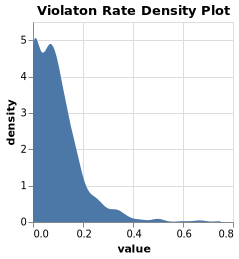

In [6]:
@vlplot(
  data = doctors,
  mark = :area, # It's an area plot
  transform = [{density = "violation_rate"}], 
  x = {"value:q"},
  y = {"density:q"},  # Density variable created
  title = "Violaton Rate Density Plot",
  height = 200,
  width = 200
)

## Summary
A list of violation rate of doctors as well as the distribution was produced in the context of surgery on benign polyps.  Action must be taken to lower this violation rate as it is associated with higher rates of mortality, adverse size effects and higher cost compared to endoscopy. 